# Based in Chapter 2 of Sutton and Barto

In [1]:
!pip install gym==0.23.1
!pip install tqdm

In [14]:
import os
import sys
from typing import Optional, Union, List, Tuple
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm
import pandas as pd

/var/folders/qd/qcmv0_xj6ysfn9j044hp74fc0000gn/T/ipykernel_97978/2181883344.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
ObsType = int
ActType = int

class MultiArmedBandit(gym.Env):
    '''
    A class representing a multi-armed bandit environment, based on OpenAI Gym's Env class.

    Attributes:
        action_space (gym.spaces.Discrete): The space of possible actions, representing the arms of the bandit.
        observation_space (gym.spaces.Discrete): The space of possible observations.
        num_arms (int): The number of arms in the bandit.
        stationary (bool): Indicates whether the reward distribution (i.e. the arm_reward_means) is stationary or not.
        arm_reward_means (np.ndarray): The mean rewards for each arm.
    '''
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete
    num_arms: int
    stationary: bool
    arm_reward_means: np.ndarray

    def __init__(self, num_arms=10, stationary=True):
        '''
        Initializes the MultiArmedBandit environment.

        Args:
            num_arms (int): The number of arms for the bandit. Defaults to 10.
            stationary (bool): Whether the bandit has a stationary reward distribution. Defaults to True.
        '''
        super().__init__()
        self.num_arms = num_arms
        self.stationary = stationary
        self.observation_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(num_arms)
        self.reset()

    def step(self, arm: ActType) -> Tuple[ObsType, float, bool, dict]:
        '''
        Takes an action by choosing an arm and returns the result of the action.

        Args:
            arm (ActType): The selected arm to pull in the bandit.

        Returns:
            Tuple[ObsType, float, bool, dict]: A tuple containing the observation, reward, done flag, and additional info.
        '''
        assert self.action_space.contains(arm)
        if not self.stationary:
            q_drift = self.np_random.normal(loc=0.0, scale=0.01, size=self.num_arms)
            self.arm_reward_means += q_drift
            self.best_arm = int(np.argmax(self.arm_reward_means))
        reward = self.np_random.normal(loc=self.arm_reward_means[arm], scale=1.0)
        obs = 0
        done = False
        info = dict(best_arm=self.best_arm)
        return (obs, reward, done, info)

    def reset(self, seed: Optional[int]=None, options=None) -> ObsType:
        '''
        Resets the environment to its initial state.

        Args:
            seed (Optional[int]): The seed for random number generation. Defaults to None.
            return_info (bool): If True, return additional info. Defaults to False.
            options (dict): Additional options for environment reset. Defaults to None.

        Returns:
            ObsType: The initial observation.
        '''
        super().reset(seed=seed)
        if self.stationary:
            self.arm_reward_means = self.np_random.normal(loc=0.0, scale=1.0, size=self.num_arms)
        else:
            self.arm_reward_means = np.zeros(shape=[self.num_arms])
        self.best_arm = int(np.argmax(self.arm_reward_means))
        return 0

    def render(self, mode="human"):
        '''
        Renders the state of the environment, in the form of a violin plot.
        '''
        assert mode == "human", f"Mode {mode} not supported!"
        bandit_samples = []
        for arm in range(self.action_space.n):
            bandit_samples += [np.random.normal(loc=self.arm_reward_means[arm], scale=1.0, size=1000)]
        plt.violinplot(bandit_samples, showmeans=True)
        plt.xlabel("Bandit Arm")
        plt.ylabel("Reward Distribution")
        plt.show()

In [4]:
gym.envs.registration.register(
    id="ArmedBanditTestbed-v0",
    entry_point=MultiArmedBandit,
    max_episode_steps=1000,
    nondeterministic=True,
    reward_threshold=1.0,
    kwargs={"num_arms": 10, "stationary": True},
)

env = gym.make("ArmedBanditTestbed-v0")
print(f"Our env inside its wrappers looks like: {env}")

Our env inside its wrappers looks like: <TimeLimit<OrderEnforcing<MultiArmedBandit<ArmedBanditTestbed-v0>>>>


In [5]:
class Agent:
    '''
    Base class for agents in a multi-armed bandit environment

    (you do not need to add any implementation here)
    '''
    rng: np.random.Generator

    def __init__(self, num_arms: int, seed: int):
        self.num_arms = num_arms
        self.reset(seed)

    def get_action(self) -> ActType:
        raise NotImplementedError()

    def observe(self, action: ActType, reward: float, info: dict) -> None:
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)


def run_episode(env: gym.Env, agent: Agent, seed: int):
    '''
    Runs a single episode of interaction between an agent and an environment.

    Args:
        env (gym.Env): The environment in which the agent operates.
        agent (Agent): The agent that takes actions in the environment.
        seed (int): The seed for random number generation to ensure reproducibility.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing arrays of rewards
        received in each step and a flag indicating if the chosen arm was the best.
    '''
    (rewards, was_best) = ([], [])

    env.reset(seed=seed)
    agent.reset(seed=seed)

    done = False
    while not done:
        arm = agent.get_action()
        (obs, reward, done, info) = env.step(arm)
        agent.observe(arm, reward, info)
        rewards.append(reward)
        was_best.append(1 if arm == info["best_arm"] else 0)

    rewards = np.array(rewards, dtype=float)
    was_best = np.array(was_best, dtype=int)
    return (rewards, was_best)


def run_agent(env: gym.Env, agent: Agent, n_runs=200, base_seed=1):
    all_rewards = []
    all_was_bests = []
    base_rng = np.random.default_rng(base_seed)
    for n in tqdm(range(n_runs)):
        seed = base_rng.integers(low=0, high=10_000, size=1).item()
        (rewards, corrects) = run_episode(env, agent, seed)
        all_rewards.append(rewards)
        all_was_bests.append(corrects)
    return (np.array(all_rewards), np.array(all_was_bests))

In [21]:
class RandomAgent(Agent):

    def get_action(self) -> ActType:
        return self.rng.integers(low=0, high=self.num_arms)

    def __repr__(self):
        return "RandomAgent"


num_arms = 10
stationary = True
env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)
agent = RandomAgent(num_arms, 0)
all_rewards, all_corrects = run_agent(env, agent)

print(f"Expected correct freq: {1/10}, actual: {all_corrects.mean():.6f}")
assert np.isclose(all_corrects.mean(), 1/10, atol=0.05), "Random agent is not random enough!"

print(f"Expected average reward: 0.0, actual: {all_rewards.mean():.6f}")
assert np.isclose(all_rewards.mean(), 0, atol=0.05), "Random agent should be getting mean arm reward, which is zero."

print("All tests passed!")  

100%|██████████| 200/200 [00:00<00:00, 375.15it/s]

Expected correct freq: 0.1, actual: 0.099565
Expected average reward: 0.0, actual: 0.006279
All tests passed!


In [28]:
def moving_avg(data: np.ndarray, window_size: int) -> np.ndarray:
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_rewards(
    all_rewards: List[np.ndarray], 
    names: List[str],
    moving_avg_window: Optional[int] = 15,
):
    plt.figure(figsize=(10, 6))
    plt.title("Mean reward over all runs")
    for rewards, name in zip(all_rewards, names):
        rewards_avg = rewards.mean(axis=0)
        print(rewards_avg)
        if moving_avg_window is not None:
            rewards_avg = moving_avg(rewards_avg, moving_avg_window)
            print(f'new: {rewards_avg}')
        plt.plot(rewards_avg, label=name)
    plt.xlabel("Episodes")
    plt.ylabel("Mean Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 200/200 [00:00<00:00, 386.01it/s]


RewardAveraging(eps=0.01, optimism=0)
 -> Frequency of correct arm: 0.5196
 -> Average reward: 1.2578


100%|██████████| 200/200 [00:00<00:00, 402.81it/s]


RewardAveraging(eps=0.01, optimism=5)
 -> Frequency of correct arm: 0.7465
 -> Average reward: 1.4833
[-0.10248702  0.41482435  0.40280445  0.42327178  0.57565419  0.65410877
  0.74864388  0.8603339   0.84810478  0.95396579  0.89634661  0.87921319
  0.83168109  0.91310388  0.90446794  0.95606045  0.84995689  0.88899032
  0.97850827  1.09364914  1.03159354  1.01057759  0.92276584  1.01593156
  0.91128449  1.10103417  0.88510604  1.10531462  1.08812836  0.92766404
  1.24313616  1.14297611  0.88061062  0.9873607   1.12428071  0.93925457
  1.0145142   1.02518026  1.01884548  1.17696521  1.08266538  1.24106127
  1.12514538  1.05901309  1.13759393  1.06203015  1.05418098  1.08299471
  1.1508855   1.01438263  1.02110272  1.13683861  0.97786852  1.00237516
  1.04081207  1.06318727  0.95653184  1.18953314  1.16969573  0.98974937
  1.16548483  1.14179548  0.91716205  1.02973898  1.08493442  1.12241461
  1.05533018  1.21264933  1.21829135  1.03936931  1.13391542  0.9937544
  1.17059798  0.9653845

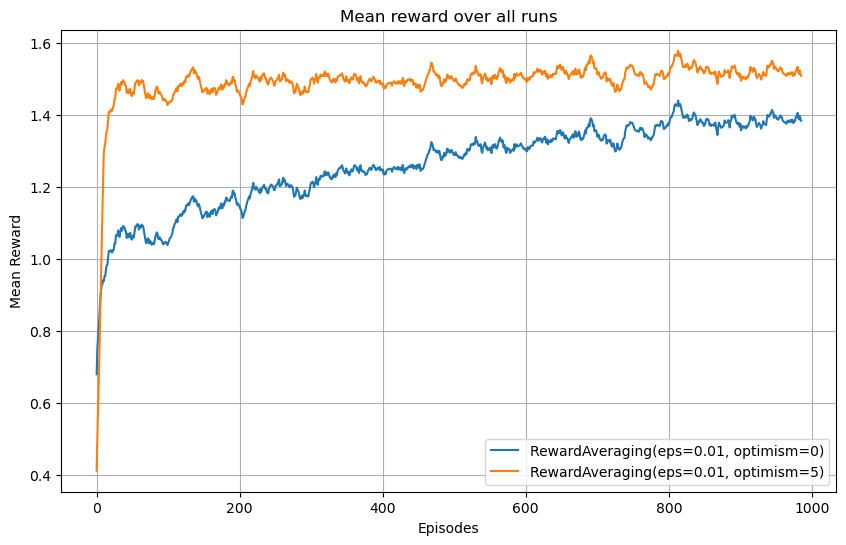

In [29]:
class RewardAveraging(Agent):
    def __init__(self, num_arms: int, seed: int, epsilon: float, optimism: float):
        self.epsilon = epsilon
        self.optimism = optimism
        super().__init__(num_arms, seed)

    def get_action(self):
        if self.rng.random() < self.epsilon:
          return self.rng.integers(0, self.num_arms)
        
        return self.Q.argmax()
        

    def observe(self, action, reward, info):
        self.N[action] += 1
        self.Q[action] += 1/self.N[action] * (reward - self.Q[action])

    def reset(self, seed: int):
        super().reset(seed)
        self.N = np.zeros(self.num_arms)
        self.Q = np.full(self.num_arms, self.optimism, dtype=float)

    def __repr__(self):
        return f"RewardAveraging(eps={self.epsilon}, optimism={self.optimism})"

N_RUNS = 200
num_arms = 10
stationary = True
names = []
all_rewards = []
env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)

for optimism in [0, 5]:
    agent = RewardAveraging(num_arms, 0, epsilon=0.01, optimism=optimism)
    (rewards, num_correct) = run_agent(env, agent, n_runs=N_RUNS, base_seed=1)
    all_rewards.append(rewards)
    names.append(str(agent))
    print(agent)
    print(f" -> Frequency of correct arm: {num_correct.mean():.4f}")
    print(f" -> Average reward: {rewards.mean():.4f}")

# utils.plot_rewards(all_rewards, names, moving_avg_window=15)

plot_rewards(all_rewards, names, moving_avg_window=15)


100%|██████████| 200/200 [00:00<00:00, 370.46it/s]


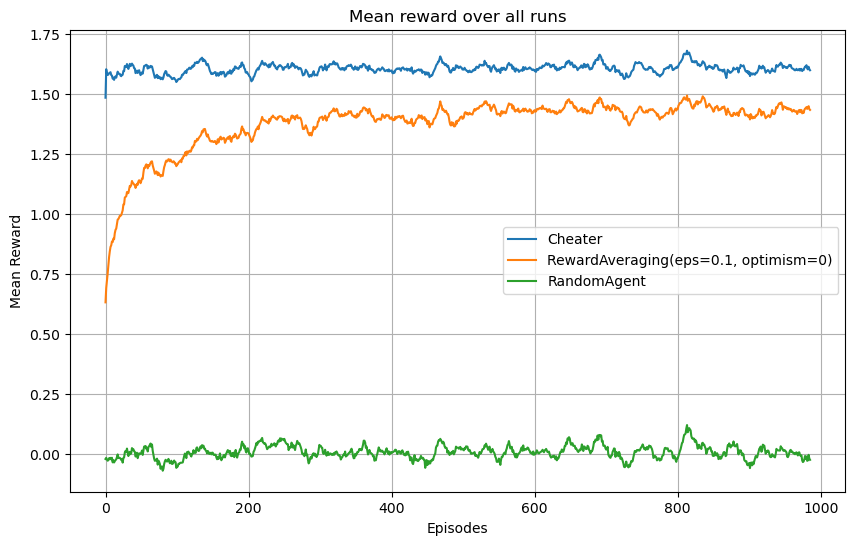

Tests passed!


In [24]:
class CheatyMcCheater(Agent):
    def __init__(self, num_arms: int, seed: int):
        super().__init__(num_arms, seed)
        self.best_arm = 0

    def get_action(self):
        return self.best_arm

    def observe(self, action: int, reward: float, info: dict):
        self.best_arm = info["best_arm"]

    def __repr__(self):
        return "Cheater"


cheater = CheatyMcCheater(num_arms, 0)
reward_averaging = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=0)
random = RandomAgent(num_arms, 0)

names = []
all_rewards = []

for agent in [cheater, reward_averaging, random]:
    (rewards, num_correct) = run_agent(env, agent, n_runs=N_RUNS, base_seed=1)
    names.append(str(agent))
    all_rewards.append(rewards)

plot_rewards(all_rewards, names, moving_avg_window=15)

assert (all_rewards[0] < all_rewards[1]).mean() < 0.001, "Cheater should be better than reward averaging"
print("Tests passed!")

100%|██████████| 200/200 [00:00<00:00, 399.87it/s]


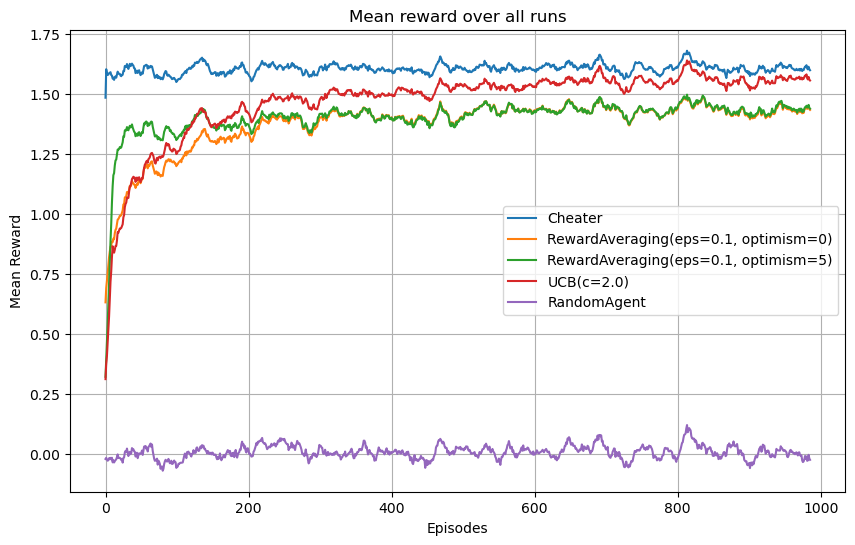

In [26]:
class UCBActionSelection(Agent):
    def __init__(self, num_arms: int, seed: int, c: float, eps: float = 1e-6):
        super().__init__(num_arms, seed)
        self.c = c
        self.eps = eps

    def get_action(self):
        # YOUR CODE HERE
        ucb = self.Q + self.c*np.sqrt(np.log(self.t)/(self.N + self.eps))
        return ucb.argmax()

    def observe(self, action, reward, info):
        # YOUR CODE HERE
        self.t += 1
        self.N[action] += 1
        self.Q[action] += 1/self.N[action] * (reward - self.Q[action])

    def reset(self, seed: int):
        # YOUR CODE HERE
        super().reset(seed)
        self.t = 1
        self.N = np.zeros(self.num_arms)
        self.Q = np.zeros(self.num_arms)

    def __repr__(self):
        return f"UCB(c={self.c})"


cheater = CheatyMcCheater(num_arms, 0)
reward_averaging = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=0)
reward_averaging_optimism = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=5)
ucb = UCBActionSelection(num_arms, 0, c=2.0)
random = RandomAgent(num_arms, 0)

names = []
all_rewards = []

for agent in [cheater, reward_averaging, reward_averaging_optimism, ucb, random]:
    (rewards, num_correct) = run_agent(env, agent, n_runs=N_RUNS, base_seed=1)
    names.append(str(agent))
    all_rewards.append(rewards)

plot_rewards(all_rewards, names, moving_avg_window=15)